# Modeling Agricultural Variables
## Python modules

In [1]:
import warnings
import time
import os

import dask
from dask.distributed import Client
import concurrent.futures

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.colors as colors

import geopandas as gpd
from shapely.geometry import Polygon
import pyarrow
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from scipy.stats import spearmanr
from scipy.linalg import LinAlgWarning
from scipy.stats import pearsonr
from hilbertcurve.hilbertcurve import HilbertCurve

import math
import seaborn as sns

This notebook will be used to prepare our feature and ground-truth data for our modeling process. At this point, we have a directory of .feather files that contain our features (see this notebook for feature generation). We want to concatentate these together, and perform the necessary operations to achieve a dataframe where a row is one observation unit; its columns are the associated features and the ground truth data that we want to train the model on. Broadly, we want our dataframe to take on the following form:

| observation_unit |  outcome_1 | outcome_2 | feature_1| feature_2 | feature_3
| ----|  ---- | ---- | -- | -- | -- |
| 1   |  $y_{1}$ | $y_{2}$ | $x_{1}$ | $x_{2}$ | $x_{3}$
| 2   |  $y_{1}$ | $y_{2}$ | $x_{1}$| $x_{2}$ | $x_{3}$

Where we can run regress `outcome_1` and `outcome_2` on our features, using the following form:

$y_{1}$ = $\beta_{1}$$x_{1}$ + $\beta_{2}$$x_{2}$ + $\beta_{3}$$x_{3}$ + $\beta_{n}$$x_{n}$ 

In our case, an observation is one SEA/year. We have ground truth data that summarizes the total crop yield, total crop loss, as well as other pertinent agricultural variables. We want our dataframe described above to look like this:

| SEA | Year | Observed Yield (Tonnes) | Observed Loss (Tonnes) | feature1| feature2 | feature3
| ----| ----| ---- | ---- | -- | -- | -- |
| 1   | 2016 | 72 | 13 | 1.23 | 3.25 | 0.123
| 2   | 2016  | 50 | 7.5 | 0.78| 1.2 | 2.4

## Mild Preprocessing
### 1. Load in the data

First, we load in the feature data. This data was aggregated in the ___ notebook

In [2]:
# Let's read in the new concatenated features:
features = pd.read_feather("/capstone/mosaiks/repos/modeling/data/features_zmb_save.feather")


In [3]:
features.head()

0    1         2         3         4    5         6         7    8  \
0  0.000185  0.0  0.000639  0.520889  0.017403  0.0  0.003055  1.075246  0.0   
1  0.000165  0.0  0.000140  0.506241  0.010501  0.0  0.001828  1.070585  0.0   
2  0.000679  0.0  0.001090  0.584611  0.021318  0.0  0.006663  1.202663  0.0   
3  0.000502  0.0  0.003195  0.692933  0.034732  0.0  0.009775  1.366068  0.0   
4  0.000162  0.0  0.003317  0.766315  0.039693  0.0  0.013185  1.480798  0.0   

     9  ...       994       995       996       997       998       999  \
0  0.0  ...  0.004387  2.898772  3.899328  0.019313  0.956588  0.000149   
1  0.0  ...  0.003691  2.874976  3.857865  0.023663  0.927871  0.000587   
2  0.0  ...  0.007180  2.960961  3.987956  0.021282  0.891021  0.000574   
3  0.0  ...  0.008007  3.097285  4.168679  0.009190  0.847190  0.000006   
4  0.0  ...  0.008061  3.172538  4.296293  0.017217  0.834277  0.000000   

         lon        lat  year  month  
0  27.800588 -16.343257  2015      7  
1  27.790588 -16.343257  2015      7  
2  27.780588 -16.353257  2015      7  
3  27.720588 -16.363257  2015      7  
4  27.730588 -16.363257  2015      7  

[5 rows x 1004 columns]

### Ground-Truth Data
Next, we read in our ground truth data, which was processed in the preprocessing notebook

In [4]:
# Name list because gpd doesn't read in column names correctly
cols = ["sea_unq", "year", "total_area_planted_ha", "total_area_harv_ha", "total_area_lost_ha", "total_harv_kg", "yield_kgha", "frac_area_harv", "frac_area_loss", "area_lost_fire", "maize", "groundnuts", "mixed_beans",  "popcorn", "sorghum", "soybeans", "sweet_potatoes", "bunding", "monocrop", "mixture", "frac_loss_drought",  "frac_loss_flood", "frac_loss_animal", "frac_loss_pests", "frac_loss_soil", "frac_loss_fert", "prop_till_plough",  "prop_till_ridge", "prop_notill", "prop_hand", "prop_mono", "prop_mix", "log_maize",  "log_sweetpotatoes", "log_groundnuts", "log_soybeans", "loss_ind", "drought_loss_ind", "flood_loss_ind", "animal_loss_ind", "pest_loss_ind", "geometry"]

# Read in the survey data
country_sea = gpd.read_file('/capstone/mosaiks/repos/preprocessing/data/ground_data_spatial/updated_data.shp')
country_sea.columns = cols
country_sea.head()

ERROR 1: PROJ: proj_create_from_database: Open of /Users/andrewbartnik/.conda/envs/mosaiks/share/proj failed


sea_unq    year  total_area_planted_ha  total_area_harv_ha  \
0        1  2009.0                34.9725             34.9725   
1        1  2010.0                32.2150             26.7625   
2        1  2011.0                60.4075             59.7525   
3        1  2012.0                64.6175             57.6025   
4        1  2013.0               325.5000            282.7500   

   total_area_lost_ha  total_harv_kg   yield_kgha  frac_area_harv  \
0              0.0000        57563.0  1645.950390        1.000000   
1              5.4525        69925.0  2170.572715        0.830747   
2              0.6550       120614.0  1996.672599        0.989157   
3              7.0150       105990.0  1640.267729        0.891438   
4             42.7500         1975.0     6.067588        0.868664   

   frac_area_loss  area_lost_fire  ...  log_maize  log_sweetpotatoes  \
0        0.000000             0.0  ...   7.419992           8.455318   
1        0.169253             0.0  ...   7.479710           9.021598   
2        0.010843             0.0  ...   7.563515           8.759924   
3        0.108562             0.0  ...   7.248387           8.836374   
4        0.131336             0.0  ...   0.213193               -inf   

   log_groundnuts  log_soybeans  loss_ind  drought_loss_ind  flood_loss_ind  \
0        7.276696      7.107469       0.0               0.0             0.0   
1        8.309147      7.377759       1.0               0.0             0.0   
2        8.066608          -inf       0.0               0.0             0.0   
3        8.067501      6.476972       1.0               1.0             0.0   
4        4.264244          -inf       1.0               0.0             0.0   

   animal_loss_ind  pest_loss_ind  \
0              0.0            0.0   
1              0.0            1.0   
2              0.0            0.0   
3              0.0            0.0   
4              0.0            0.0   

                                            geometry  
0  POLYGON ((27.82327 -13.65772, 27.82294 -13.657...  
1  POLYGON ((27.82327 -13.65772, 27.82294 -13.657...  
2  POLYGON ((27.82327 -13.65772, 27.82294 -13.657...  
3  POLYGON ((27.82327 -13.65772, 27.82294 -13.657...  
4  POLYGON ((27.82327 -13.65772, 27.82294 -13.657...  

[5 rows x 42 columns]

We're going to make another object `sea_unq_join` which contains the spatial information and a unique key for each SEA. This will be handy later, when we need to join the features to the ground-truth data.

In [5]:
# Filter country_sea for unique values of 'seq_unq' and 'geometry'
sea_unq_join = country_sea[['sea_unq', 'geometry']].drop_duplicates()

# Display the filtered DataFrame
print(sea_unq_join)


      sea_unq                                           geometry
0           1  POLYGON ((27.82327 -13.65772, 27.82294 -13.657...
10          2  POLYGON ((27.99349 -13.46497, 27.99352 -13.464...
20          3  POLYGON ((28.09909 -13.51864, 28.09867 -13.516...
29          4  POLYGON ((28.31924 -13.42915, 28.31911 -13.426...
38          5  POLYGON ((28.39982 -13.51544, 28.40012 -13.514...
...       ...                                                ...
3571      388  POLYGON ((25.07771 -14.63920, 25.07732 -14.638...
3578      389  POLYGON ((22.74142 -14.00343, 22.73856 -14.002...
3585      390  POLYGON ((23.08604 -14.20026, 23.08957 -14.202...
3592      391  POLYGON ((24.36764 -16.62208, 24.36564 -16.621...
3599      392  POLYGON ((23.23962 -16.31204, 23.23876 -16.312...

[392 rows x 2 columns]


### 2. Organize the features by growing season



In [6]:
# Organize the features by growing season
# Carry months October, November, and December over to the following year's data
# These months represent the start of the growing season for the following year's maize yield
year_end = 2022

features['year'] = np.where(
    features['month'].isin([10, 11, 12]),
    features['year'] + 1, 
    features['year'])

features_gs = features[features['year'] <= year_end]

features_gs.sort_values(['year', 'month'], inplace=True)

/tmp/ipykernel_1310838/261356123.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_gs.sort_values(['year', 'month'], inplace=True)


### 3. Convert the features into a geo dataframe

We first create a GeoDataFrame (`features_new_gdf`) from the DataFrame features, using the longitude and latitude columns to create the geometry column (geospatial points) and specifying the CRS (Coordinate Reference System) as EPSG:4326.

In [7]:
# Create a geodataframe of the new features
features_new_gdf = gpd.GeoDataFrame(
    features_gs, 
    geometry = gpd.points_from_xy(x = features_gs.lon, y = features_gs.lat), 
    crs='EPSG:4326'
)

In [8]:
# Notes: Have to change the year, get an error rn. Also, check to make sure the number of cells is correct
features_new_gdf = features_new_gdf.replace([np.inf, -np.inf], np.nan)
features_new_gdf.head()

0    1         2         3         4    5         6         7    8  \
0  0.000185  0.0  0.000639  0.520889  0.017403  0.0  0.003055  1.075246  0.0   
1  0.000165  0.0  0.000140  0.506241  0.010501  0.0  0.001828  1.070585  0.0   
2  0.000679  0.0  0.001090  0.584611  0.021318  0.0  0.006663  1.202663  0.0   
3  0.000502  0.0  0.003195  0.692933  0.034732  0.0  0.009775  1.366068  0.0   
4  0.000162  0.0  0.003317  0.766315  0.039693  0.0  0.013185  1.480798  0.0   

     9  ...       995       996       997       998       999        lon  \
0  0.0  ...  2.898772  3.899328  0.019313  0.956588  0.000149  27.800588   
1  0.0  ...  2.874976  3.857865  0.023663  0.927871  0.000587  27.790588   
2  0.0  ...  2.960961  3.987956  0.021282  0.891021  0.000574  27.780588   
3  0.0  ...  3.097285  4.168679  0.009190  0.847190  0.000006  27.720588   
4  0.0  ...  3.172538  4.296293  0.017217  0.834277  0.000000  27.730588   

         lat  year  month                    geometry  
0 -16.343257  2015      7  POINT (27.80059 -16.34326)  
1 -16.343257  2015      7  POINT (27.79059 -16.34326)  
2 -16.353257  2015      7  POINT (27.78059 -16.35326)  
3 -16.363257  2015      7  POINT (27.72059 -16.36326)  
4 -16.363257  2015      7  POINT (27.73059 -16.36326)  

[5 rows x 1005 columns]

## Pivot Wider by months

Since our ground-truth data has an annual resolution, we need to pivot our monthly features wider so that each observation contains all of the features for the full year. The main goal in this next step is to aggregate the features data into years while preserving the monthly information as separate columns. To achieve this, the code performs the following steps:

1. Separate the 'geometry' column temporarily to avoid duplicating it during unstacking.
2. Create a multi-level index using 'lon', 'lat', 'year', and 'month' in the DataFrame.
3. Unstack the DataFrame, transforming the innermost index level ('month') into new columns, creating a wide format DataFrame where each row represents a unique combination of 'lon', 'lat', and 'year', and the columns contain the values of the original features for each month.
4. Merge the 'geometry' column back into the DataFrame.

The resulting DataFrame contains the features aggregated by year with separate columns for each month's data. The naming convention will be `featurenumber_monthnumber`, so `587_12` corresponds to the 587th feature generated in December for that year 

In [ ]:
# Store the 'geometry' column separately before unstacking
geometry_col = features_new_gdf[['lon', 'lat', 'geometry']].drop_duplicates(subset=['lon', 'lat'])

# Perform the unstacking operation without the 'geometry' column
features_gs_no_geometry = features_gs.drop(columns=['geometry'])
features = features_gs_no_geometry.set_index(['lon', 'lat', 'year', 'month']).unstack()
features.columns = features.columns.map(lambda x: '{}_{}'.format(*x))

# Merge the 'geometry' column back into the features DataFrame
features = features.reset_index().merge(geometry_col, on=['lon', 'lat'])


In [ ]:

# Convert the 'features' DataFrame to a GeoDataFrame
features_gdf = gpd.GeoDataFrame(features, geometry=features['geometry'], crs='EPSG:4326')

In [ ]:
features_gdf
# Calculate the total number of NaN cells
total_na_cells = features_gdf.isna().sum().sum()
print(f"Total NaN cells: {total_na_cells}")

In [ ]:
features_gdf

In [ ]:

features_gdf = features_gdf.replace([np.inf, -np.inf], np.nan)
# Remove the geometry column from the DataFrame
features_gdf = features_gdf.set_index(['year', 'lat', 'lon'])
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
imputer.fit_transform(features_gdf)
features_gdf[:] = imputer.transform(features_gdf)
features_gdf = features_gdf.reset_index()
# Add the geometry column back to the DataFrame

## Join features to ground data

In [52]:
# Now lets combine the sea data 
spatial_join = gpd.sjoin(features_gdf, sea_unq_join, how='right', predicate = 'within')

In [53]:
spatial_join.head()

index_left       lon        lat    year  0_1  0_2  0_3  0_4  0_5  0_6  ...  \
0     40939.0  27.81466 -13.669357  2020.0  NaN  0.0  NaN  0.0  0.0  0.0  ...   
0     40936.0  27.81466 -13.669357  2017.0  NaN  NaN  0.0  NaN  0.0  0.0  ...   
0     40940.0  27.81466 -13.669357  2021.0  NaN  NaN  NaN  0.0  0.0  0.0  ...   
0     40941.0  27.81466 -13.669357  2022.0  NaN  NaN  NaN  NaN  0.0  0.0  ...   
0     40934.0  27.81466 -13.669357  2015.0  NaN  NaN  NaN  NaN  NaN  NaN  ...   

      999_5     999_6     999_7     999_8     999_9    999_10    999_11  \
0  0.474246  0.417571  0.135569  0.003355  0.004876  0.003185  0.187867   
0  0.532948  0.469076  0.007786  0.006779  0.004811  0.001675  0.029891   
0  0.645601  0.673485  0.631725  0.004959  0.001359  0.001627  0.052683   
0  0.411212  0.286194  0.004574  0.006873  0.003651  0.087053  0.001866   
0       NaN       NaN       NaN       NaN  0.037791       NaN       NaN   

     999_12  sea_unq                                           geometry  
0  0.156783        1  POLYGON ((27.82327 -13.65772, 27.82294 -13.657...  
0       NaN        1  POLYGON ((27.82327 -13.65772, 27.82294 -13.657...  
0       NaN        1  POLYGON ((27.82327 -13.65772, 27.82294 -13.657...  
0  0.001954        1  POLYGON ((27.82327 -13.65772, 27.82294 -13.657...  
0       NaN        1  POLYGON ((27.82327 -13.65772, 27.82294 -13.657...  

[5 rows x 12006 columns]

In [54]:
features_join = spatial_join.merge(country_sea, on=['year', 'sea_unq'], how='inner')

In [55]:
# Drop the redundant independent lon and lat columns because now that they are in a separate geometry column
features_join = features_join.drop(['geometry_x', 'index_left'], axis = 1)
    # Store the geometry column separately
geometry_col = features_join['geometry_y']
    # Remove the geometry column from the DataFrame
features_join = features_join.drop(columns=['geometry_y'])

In [56]:

features_join = features_join.replace([np.inf, -np.inf], np.nan)
# Remove the geometry column from the DataFrame
features_join = features_join.set_index(['year', 'sea_unq'])
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
imputer.fit_transform(features_join)
features_join[:] = imputer.transform(features_join)
features_join = features_join.reset_index()
# Add the geometry column back to the DataFrame


In [57]:
features_join = pd.concat([features_join, geometry_col], axis=1)
features_join = features_join.drop(['lat', 'lon'], axis = 1)


In [58]:
features_join['geometry'] = geometry_col
grouped_features = features_join.groupby(['year', 'sea_unq']).mean()


/tmp/ipykernel_2493574/3366700449.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped_features = features_join.groupby(['year', 'sea_unq']).mean()


In [61]:
grouped_features

0_1       0_2       0_3       0_4       0_5       0_6  \
year   sea_unq                                                               
2016.0 1        0.000000  0.000863  0.000783  0.000000  0.000000  0.000000   
       2        0.000069  0.000863  0.000783  0.000000  0.000002  0.000014   
       7        0.001141  0.000863  0.000783  0.000329  0.000000  0.000000   
       9        0.001131  0.000863  0.000783  0.000006  0.000004  0.000010   
       10       0.001131  0.000863  0.000783  0.000000  0.000000  0.000000   
...                  ...       ...       ...       ...       ...       ...   
2021.0 388      0.001131  0.000076  0.000106  0.000075  0.000046  0.000112   
       389      0.001131  0.000863  0.000018  0.000104  0.000202  0.000424   
       390      0.000821  0.000345  0.000180  0.000227  0.000306  0.000457   
       391      0.001131  0.000863  0.000353  0.000323  0.000244  0.000222   
       392      0.001661  0.001136  0.000874  0.000720  0.000429  0.000714   

                     0_7           0_8       0_9      0_10  ...  prop_mix  \
year   sea_unq                                              ...             
2016.0 1        0.000000  6.157999e-06  0.000207  0.001568  ...  0.000000   
       2        0.000047  6.299240e-05  0.000168  0.001568  ...  0.000000   
       7        0.000000  1.008277e-03  0.001360  0.002211  ...  0.181102   
       9        0.000014  2.590917e-05  0.000110  0.001568  ...  0.069018   
       10       0.000000  3.113844e-07  0.000012  0.001568  ...  0.000000   
...                  ...           ...       ...       ...  ...       ...   
2021.0 388      0.000144  8.372727e-04  0.001012  0.001649  ...  0.000000   
       389      0.000395  7.513932e-04  0.001059  0.002266  ...  0.000000   
       390      0.000474  9.321970e-04  0.001530  0.002215  ...  0.000000   
       391      0.000311  1.540414e-03  0.001683  0.002434  ...  0.000000   
       392      0.001367  2.518747e-03  0.003055  0.004092  ...  0.000000   

                log_maize  log_sweetpotatoes  log_groundnuts  log_soybeans  \
year   sea_unq                                                               
2016.0 1         4.058626           6.364023        5.935403      6.565149   
       2         3.179960           6.364023        5.935403      6.565149   
       7         3.387211           0.689155        5.935403      6.565149   
       9         2.703935           6.364023       -1.408767      6.565149   
       10        3.714757           2.525729        3.354421      6.565149   
...                   ...                ...             ...           ...   
2021.0 388       7.939201           9.367183        8.098897      7.336848   
       389       7.844633           6.364023        8.048788      6.565149   
       390       7.792168           7.863267        8.154788      6.565149   
       391       7.652396           6.364023        8.065208      6.565149   
       392       7.641359           6.364023        7.960925      6.565149   

                loss_ind  drought_loss_ind  flood_loss_ind  animal_loss_ind  \
year   sea_unq                                                                
2016.0 1             0.0               0.0             0.0              0.0   
       2             0.0               0.0             0.0              0.0   
       7             1.0               1.0             0.0              0.0   
       9             1.0               0.0             0.0              0.0   
       10            1.0               0.0             0.0              0.0   
...                  ...               ...             ...              ...   
2021.0 388           0.0               0.0             0.0              0.0   
       389           1.0               1.0             0.0              0.0   
       390           1.0               0.0             0.0              0.0   
       391           1.0               0.0             1.0              0.0   
       392           1.0               0.

In [67]:
grouped_features.to_csv('/capstone/mosaiks/repos/preprocessing/data/grouped_features.csv', index=True)

## Unlabelled features

ERROR 1: PROJ: proj_create_from_database: Open of /Users/andrewbartnik/.conda/envs/mosaiks/share/proj failed


<Axes: >

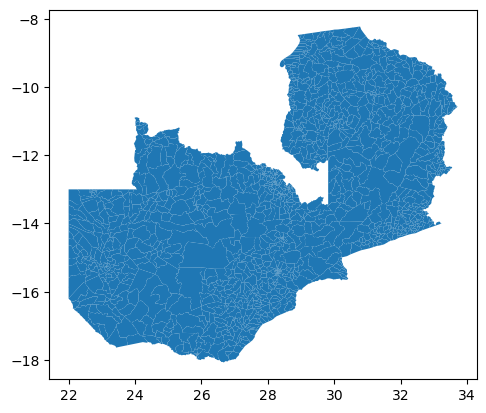

In [2]:
shapefile_path = '/capstone/mosaiks/repos/modeling/data/zambian_ward_boundries/popward.shp'

zambia_district_boundaries = gpd.read_file(shapefile_path)

# Let's read in the new concatenated features:
features = pd.read_feather("/capstone/mosaiks/repos/modeling/data/features_zmb_save.feather")

zambia_district_boundaries.plot()



In [3]:
# Filter for unique values of 'geometry'
ward_unq_join = zambia_district_boundaries[['geometry']].drop_duplicates()

# Assign a unique numerical identifier to each geometry
ward_unq_join['ward_id'] = np.arange(len(ward_unq_join))
# Display the filtered DataFrame
print(ward_unq_join)

                                               geometry  ward_id
0     POLYGON ((22.80895 -15.15215, 22.80747 -15.155...        0
1     POLYGON ((22.69203 -14.98920, 22.69243 -14.989...        1
2     POLYGON ((22.50557 -14.97359, 22.50855 -14.974...        2
3     POLYGON ((22.65805 -14.98798, 22.65975 -14.988...        3
4     POLYGON ((22.70868 -15.13386, 22.70826 -15.133...        4
...                                                 ...      ...
1411  POLYGON ((26.39001 -12.17563, 26.39083 -12.175...     1411
1412  POLYGON ((28.85148 -9.18543, 28.85182 -9.18544...     1412
1413  POLYGON ((29.50465 -9.61324, 29.50846 -9.61495...     1413
1414  POLYGON ((28.31243 -15.47706, 28.31198 -15.477...     1414
1415  POLYGON ((26.09249 -17.47196, 26.08855 -17.487...     1415

[1416 rows x 2 columns]


In [4]:
zambia_district_boundaries

ID    WARD_NAME  PROV_CODE     PROVINCENA  DISTRICT_C DISTRICTNA  \
0     100113408      Mapungu        1.0        Western      1001.0     Kalabo   
1     100113409    Luanginga        1.0        Western      1001.0     Kalabo   
2     100113410       Liumba        1.0        Western      1001.0     Kalabo   
3     100113411         Yuka        1.0        Western      1001.0     Kalabo   
4     100113412       Buleya        1.0        Western      1001.0     Kalabo   
...         ...          ...        ...            ...         ...        ...   
1411   80611011  Tuvwanganai        8.0  North-Western       806.0    Solwezi   
1412   40606605   Kashikishi        4.0        Luapula       702.0  Nchelenge   
1413   40205809      Mulundu        4.0        Luapula       402.0   Kawambwa   
1414   50407607       Libala        5.0         Lusaka       504.0     Lusaka   
1415   90512113     Katapazi        9.0       Southern       905.0  Kazungula   

      CONST_CODE WARD_CODE   perimeter  Shape_Leng  Shape_Area  \
0          134.0        08   59.835569    0.547729    0.010040   
1          134.0        09   17.512021    0.160195    0.001180   
2          134.0        10   54.226736    0.507828    0.006990   
3          134.0        11   90.136126    0.827044    0.018422   
4          134.0        12   61.102504    0.559915    0.008911   
...          ...       ...         ...         ...         ...   
1411       110.0        11   17.304878    0.153453    0.000803   
1412        66.0        05  167.699521    1.413525    0.069055   
1413        58.0        09  120.613286    1.085770    0.049460   
1414        76.0        07   15.840070    0.119842    0.000551   
1415       121.0        13  163.946811    1.513844    0.068046   

                                               geometry  
0     POLYGON ((22.80895 -15.15215, 22.80747 -15.155...  
1     POLYGON ((22.69203 -14.98920, 22.69243 -14.989...  
2     POLYGON ((22.50557 -14.97359, 22.50855 -14.974...  
3     POLYGON ((22.65805 -14.98798, 22.65975 -14.988...  
4     POLYGON ((22.70868 -15.13386, 22.70826 -15.133...  
...                                                 ...  
1411  POLYGON ((26.39001 -12.17563, 26.39083 -12.175...  
1412  POLYGON ((28.85148 -9.18543, 28.85182 -9.18544...  
1413  POLYGON ((29.50465 -9.61324, 29.50846 -9.61495...  
1414  POLYGON ((28.31243 -15.47706, 28.31198 -15.477...  
1415  POLYGON ((26.09249 -17.47196, 26.08855 -17.487...  

[1416 rows x 12 columns]

In [5]:
# Organize the features by growing season
# Carry months October, November, and December over to the following year's data
# These months represent the start of the growing season for the following year's maize yield
year_end = 2022

features['year'] = np.where(
    features['month'].isin([10, 11, 12]),
    features['year'] + 1, 
    features['year'])

features_gs = features[features['year'] <= year_end]

features_gs.sort_values(['year', 'month'], inplace=True)

/tmp/ipykernel_2227764/261356123.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_gs.sort_values(['year', 'month'], inplace=True)


In [6]:
# Create a geodataframe of the new features
features_new_gdf = gpd.GeoDataFrame(
    features_gs, 
    geometry = gpd.points_from_xy(x = features_gs.lon, y = features_gs.lat), 
    crs='EPSG:4326'
)

# Notes: Have to change the year, get an error rn. Also, check to make sure the number of cells is correct
features_new_gdf = features_new_gdf.replace([np.inf, -np.inf], np.nan)

In [7]:
# Store the 'geometry' column separately before unstacking
geometry_col = features_new_gdf[['lon', 'lat', 'geometry']].drop_duplicates(subset=['lon', 'lat'])

# Perform the unstacking operation without the 'geometry' column
features_gs_no_geometry = features_gs.drop(columns=['geometry'])
features = features_gs_no_geometry.set_index(['lon', 'lat', 'year', 'month']).unstack()
features.columns = features.columns.map(lambda x: '{}_{}'.format(*x))

# Merge the 'geometry' column back into the features DataFrame
features = features.reset_index().merge(geometry_col, on=['lon', 'lat'])

In [8]:
# Create a geodataframe of the new features
features_new_gdf = gpd.GeoDataFrame(
    features, 
    geometry = features.geometry, 
    crs='EPSG:4326'
)

In [9]:
features_new_gdf

lon        lat  year       0_1       0_2       0_3       0_4  \
0       22.130588 -15.793257  2015       NaN       NaN       NaN       NaN   
1       22.130588 -15.793257  2016       NaN  0.005873       NaN  0.000000   
2       22.130588 -15.793257  2017       NaN       NaN       NaN  0.001165   
3       22.130588 -15.793257  2018  0.003073       NaN       NaN  0.000001   
4       22.130588 -15.793257  2019  0.003648  0.002528  0.002732  0.002450   
...           ...        ...   ...       ...       ...       ...       ...   
470054  33.520588 -10.243257  2018       NaN  0.000000       NaN       NaN   
470055  33.520588 -10.243257  2019  0.000000       NaN       NaN  0.000000   
470056  33.520588 -10.243257  2020       NaN       NaN       NaN  0.000000   
470057  33.520588 -10.243257  2021       NaN       NaN  0.000000       NaN   
470058  33.520588 -10.243257  2022       NaN       NaN       NaN       NaN   

             0_5       0_6       0_7  ...     999_4     999_5     999_6  \
0            NaN       NaN       NaN  ...       NaN       NaN       NaN   
1       0.000000  0.002212  0.000000  ...  1.000000  1.000000  0.000319   
2       0.001032  0.001036  0.001240  ...  0.001100  0.000961  0.000885   
3       0.000136  0.000202  0.000821  ...  0.004816  0.002028  0.001336   
4       0.002431  0.002544  0.002851  ...  0.000800  0.000448  0.000247   
...          ...       ...       ...  ...       ...       ...       ...   
470054  0.000000  0.000000  0.000000  ...       NaN  0.000477  0.000219   
470055  0.000000  0.000000  0.000000  ...  0.000670  0.000224  0.000388   
470056  0.000000       NaN  0.000000  ...  0.000693  0.000339       NaN   
470057  0.000000  0.000000  0.000000  ...       NaN  0.000395  0.000228   
470058  0.000012  0.000000  0.000000  ...       NaN  0.000483  0.000514   

           999_7     999_8     999_9    999_10   999_11    999_12  \
0            NaN       NaN  0.000036       NaN      NaN       NaN   
1       1.000000  0.000042  0.000033  0.000029      NaN       NaN   
2       0.000365  0.000064  0.000046  0.000026      NaN       NaN   
3       0.000633  0.000767  0.000063  0.000040      NaN       NaN   
4       0.000145  0.000035  0.000037  0.000055  0.00023  0.000258   
...          ...       ...       ...       ...      ...       ...   
470054  0.000000  0.000000  0.000000  0.000000  0.00000       NaN   
470055  0.000000  0.000000  0.000000  0.000647  0.00000  0.000000   
470056  0.000001  0.000000  0.000000  0.000000  0.00000  0.010146   
470057  0.000023  0.000000  0.000000  0.000000  0.00000       NaN   
470058  0.000025  0.000000  0.000000       NaN  0.00000  0.005698   

                          geometry  
0       POINT (22.13059 -15.79326)  
1       POINT (22.13059 -15.79326)  
2       POINT (22.13059 -15.79326)  
3       POINT (22.13059 -15.79326)  
4       POINT (22.13059 -15.79326)  
...                            ...  
470054  POINT (33.52059 -10.24326)  
470055  POINT (33.52059 -10.24326)  
470056  POINT (33.52059 -10.24326)  
470057  POINT (33.52059 -10.24326)  
470058  POINT (33.52059 -10.24326)  

[470059 rows x 12004 columns]

In [10]:
# Now lets combine the sea data 
spatial_join = gpd.sjoin(features_new_gdf, ward_unq_join, how='right', predicate = 'within')

/tmp/ipykernel_2227764/1122093713.py:2: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84" ...

  spatial_join = gpd.sjoin(features_new_gdf, ward_unq_join, how='right', predicate = 'within')


In [11]:
spatial_join

index_left        lon        lat    year       0_1       0_2       0_3  \
0        18030.0  22.730588 -15.053257  2022.0       NaN  0.003541  0.003555   
0        18023.0  22.730588 -15.053257  2015.0       NaN       NaN       NaN   
0        18024.0  22.730588 -15.053257  2016.0       NaN  0.003176       NaN   
0        18025.0  22.730588 -15.053257  2017.0       NaN       NaN       NaN   
0        18026.0  22.730588 -15.053257  2018.0  0.002030       NaN  0.000000   
...          ...        ...        ...     ...       ...       ...       ...   
1415    153894.0  26.080588 -17.473257  2016.0  0.000000       NaN       NaN   
1415    153893.0  26.080588 -17.473257  2015.0       NaN       NaN       NaN   
1415    153898.0  26.080588 -17.473257  2020.0  0.001898  0.000023  0.000034   
1415    153896.0  26.080588 -17.473257  2018.0  0.000123       NaN       NaN   
1415    153899.0  26.080588 -17.473257  2021.0       NaN       NaN  0.000020   

           0_4       0_5       0_6  ...     999_5     999_6     999_7  \
0     0.001752  0.001398  0.001469  ...  0.003310  0.002417  0.001392   
0          NaN       NaN       NaN  ...       NaN       NaN       NaN   
0     0.002474  0.001768  0.001466  ...  0.001270  0.000877  0.000693   
0     0.000181  0.000135  0.000193  ...  0.004579  0.003234  0.002570   
0     0.000000  0.000000  0.000007  ...  0.006202  0.004043  0.003652   
...        ...       ...       ...  ...       ...       ...       ...   
1415  0.000000  0.000138  0.000842  ...  0.002543  0.000246  0.000068   
1415       NaN       NaN       NaN  ...       NaN       NaN       NaN   
1415  0.000030  0.000114  0.000131  ...  0.002700  0.002252  0.001259   
1415  0.000009  0.000011  0.000005  ...  0.004768  0.003698  0.001817   
1415  0.000018  0.000017  0.000020  ...  0.004062  0.002862  0.002118   

         999_8     999_9    999_10    999_11    999_12  \
0     0.001687  0.000812  0.000241  0.000365  0.000645   
0          NaN  0.000187       NaN       NaN       NaN   
0     0.000319  0.000230  0.000266       NaN       NaN   
0     0.000491  0.000787  0.000105  0.000569  0.000157   
0     0.002408  0.001475  0.000435  0.000302  0.005276   
...        ...       ...       ...       ...       ...   
1415  0.000001  0.000006       NaN       NaN  1.000000   
1415       NaN  0.000000       NaN       NaN       NaN   
1415  0.000377  0.000017  0.000000  0.000082  0.000924   
1415  0.000828  0.000038  0.000023  0.000624       NaN   
1415  0.000036  0.000021  0.000016  0.000277       NaN   

                                               geometry  ward_id  
0     POLYGON ((22.80895 -15.15215, 22.80747 -15.155...        0  
0     POLYGON ((22.80895 -15.15215, 22.80747 -15.155...        0  
0     POLYGON ((22.80895 -15.15215, 22.80747 -15.155...        0  
0     POLYGON ((22.80895 -15.15215, 22.80747 -15.155...        0  
0     POLYGON ((22.80895 -15.15215, 22.80747 -15.155...        0  
...                                                 ...      ...  
1415  POLYGON ((26.09249 -17.47196, 26.08855 -17.487...     1415  
1415  POLYGON ((26.09249 -17.47196, 26.08855 -17.487...     1415  
1415  POLYGON ((26.09249 -17.47196, 26.08855 -17.487...     1415  
1415  POLYGON ((26.09249 -17.47196, 26.08855 -17.487...     1415  
1415  POLYGON ((26.09249 -17.47196, 26.08855 -17.487...     1415  

[469064 rows x 12006 columns]

In [12]:
total_na_cells = spatial_join.isna().sum().sum()
print(f"Total NaN cells: {total_na_cells}")

Total NaN cells: 1735950000
Total NaN cells: 1735950000
Total NaN cells: 1733297596


In [13]:
# Drop the redundant independent lon and lat columns because now that they are in a separate geometry column
#spatial_join = spatial_join.drop(['index_left'], axis = 1)
    # Store the geometry column separately
geometry_col = spatial_join['geometry']
    # Remove the geometry column from the DataFrame
spatial_join = spatial_join.drop(columns=['geometry'])

In [14]:

features_gdf = spatial_join.replace([np.inf, -np.inf], np.nan)
features_gdf = features_gdf.set_index(['year', 'ward_id'])
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
imputer.fit_transform(features_gdf)
features_gdf[:] = imputer.transform(features_gdf)
features_gdf = features_gdf.reset_index()
# Add the geometry column back to the DataFrame


In [15]:
features_gdf 



year  ward_id  index_left        lon        lat       0_1       0_2  \
0       2022.0        0     18030.0  22.730588 -15.053257  0.001077  0.003541   
1       2015.0        0     18023.0  22.730588 -15.053257  0.001077  0.000700   
2       2016.0        0     18024.0  22.730588 -15.053257  0.001077  0.003176   
3       2017.0        0     18025.0  22.730588 -15.053257  0.001077  0.000700   
4       2018.0        0     18026.0  22.730588 -15.053257  0.002030  0.000700   
...        ...      ...         ...        ...        ...       ...       ...   
469059  2016.0     1415    153894.0  26.080588 -17.473257  0.000000  0.000700   
469060  2015.0     1415    153893.0  26.080588 -17.473257  0.001077  0.000700   
469061  2020.0     1415    153898.0  26.080588 -17.473257  0.001898  0.000023   
469062  2018.0     1415    153896.0  26.080588 -17.473257  0.000123  0.000700   
469063  2021.0     1415    153899.0  26.080588 -17.473257  0.001077  0.000700   

             0_3       0_4       0_5  ...     999_3     999_4     999_5  \
0       0.003555  0.001752  0.001398  ...  0.001252  0.004579  0.003310   
1       0.000706  0.000395  0.000172  ...  0.058021  0.075707  0.056214   
2       0.000706  0.002474  0.001768  ...  0.058021  0.001160  0.001270   
3       0.000706  0.000181  0.000135  ...  0.058021  0.005622  0.004579   
4       0.000000  0.000000  0.000000  ...  0.012280  0.009524  0.006202   
...          ...       ...       ...  ...       ...       ...       ...   
469059  0.000706  0.000000  0.000138  ...  0.058021  1.000000  0.002543   
469060  0.000706  0.000395  0.000172  ...  0.058021  0.075707  0.056214   
469061  0.000034  0.000030  0.000114  ...  0.005601  0.005830  0.002700   
469062  0.000706  0.000009  0.000011  ...  0.058021  0.006733  0.004768   
469063  0.000020  0.000018  0.000017  ...  0.006424  0.005893  0.004062   

           999_6     999_7     999_8     999_9    999_10    999_11    999_12  
0       0.002417  0.001392  0.001687  0.000812  0.000241  0.000365  0.000645  
1       0.056737  0.036262  0.004133  0.000187  0.002924  0.004093  0.040344  
2       0.000877  0.000693  0.000319  0.000230  0.000266  0.004093  0.040344  
3       0.003234  0.002570  0.000491  0.000787  0.000105  0.000569  0.000157  
4       0.004043  0.003652  0.002408  0.001475  0.000435  0.000302  0.005276  
...          ...       ...       ...       ...       ...       ...       ...  
469059  0.000246  0.000068  0.000001  0.000006  0.002924  0.004093  1.000000  
469060  0.056737  0.036262  0.004133  0.000000  0.002924  0.004093  0.040344  
469061  0.002252  0.001259  0.000377  0.000017  0.000000  0.000082  0.000924  
469062  0.003698  0.001817  0.000828  0.000038  0.000023  0.000624  0.040344  
469063  0.002862  0.002118  0.000036  0.000021  0.000016  0.000277  0.040344  

[469064 rows x 12005 columns]

In [16]:
grouped_features = features_gdf.groupby(['year', 'ward_id']).mean()


In [40]:
grouped_features = grouped_features.reset_index()

In [41]:
# Spatially join the two GeoDataFrames based on the ward_id column
spatial_join = grouped_features.merge(ward_unq_join, on='ward_id', how='left')

In [44]:
spatial_join.drop(columns = ['index_left'], inplace = True)

In [45]:
# Create a geodataframe of the new features
features_zambia_all = gpd.GeoDataFrame(
    spatial_join, 
    geometry = spatial_join.geometry, 
    crs='EPSG:4326'
)

In [46]:
features_zambia_all['year']

0       2015.0
1       2015.0
2       2015.0
3       2015.0
4       2015.0
         ...  
9729    2022.0
9730    2022.0
9731    2022.0
9732    2022.0
9733    2022.0
Name: year, Length: 9734, dtype: float64

In [47]:
# Save the geodataframe as a .feather file
output_path = '/capstone/mosaiks/repos/modeling/data/zambia_features_10sample.feather'
features_zambia_all.to_feather(output_path)
